In [1]:
# Import Modules
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import pyprimes
import matplotlib.pyplot as plt
import seaborn as sns

# Import Functions
from mpmath import zeta
from math import floor, log
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from scipy.stats import gumbel_r, linregress 
from scipy.optimize import minimize
from timeit import default_timer, timeit 

In [2]:
# import ZetaFunctions 

In [3]:
# Loading in Cython (C wrapper)
%load_ext Cython

In [4]:
%%cython
cimport numpy as nc

import numpy

##################################################
# Prime Number Sieve
##################################################
# author: Bruno Astrolino E Silva (a.k.a Robert William Hanks)
# https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n/3035188#3035188

def primesfrom2to(unsigned long long int n) -> nc.ndarray:
    """
    As seive for computing prime numbers up to a certain point Input n>=6, Returns a array of primes, 2 <= p < n
    :param N: Provide a number (presumably large) to start computing values for
    :return: Returns an array of prime numbers up to a specified point
    """
    cdef nc.ndarray sieve
    cdef unsigned long long int i, k 
    
    sieve = numpy.ones(n//3 + (n%6==2), dtype=numpy.bool)
    for i in range(1,int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[       k*k//3     ::2*k] = False
            sieve[k*(k-2*(i&1)+4)//3::2*k] = False
    return numpy.r_[2,3,((3*numpy.nonzero(sieve)[0][1:]+1)|1)]

In [5]:
##################################################
# Prime List Generation
##################################################

try:
    # ideally prime numbers should be calculated externally or stored in a txt file
    print('File found, returning prime list...')
    text_file = open("prime.txt", "r")
    prime_num = np.array(list(map(lambda x: int(x), text_file.read().split(',')[:-1])))
    text_file.close()
    print("Primes returned up to", prime_num[-1])
    
except FileNotFoundError:
    print('File not found, generating prime list...')
    
    # Stores prime list up to 10^9 (ideally should hold 10^50)
    prime_num = primesfrom2to(int(1e9))
    
    # store the prime number list in a text file (temporary)
    f = open("prime.txt", "w")
    for i in prime_num:
        f.write("{},".format(str(i)))
    f.close()
    
    text_file = open("prime.txt", "r")
    prime_num = np.array(list(map(lambda x: int(x), text_file.read().split(',')[:-1])))
    text_file.close()
    print("Primes returned up to", prime_num[-1])

File found, returning prime list...
Primes returned up to 999999937


In [6]:
prime_num

array([        2,         3,         5, ..., 999999893, 999999929,
       999999937])

## <h1><center> NUMERICAL STUDY OF THE LARGE VALUES OF THE RIEMANN ZETA FUNCTION SUPERVISED BY PROF. L.P. ARGUIN </center></h1>

**Objectives The goal is to develop numerical methods to verify and extend conjectures about the large values of the Riemann zeta function in short intervals. The [Riemann Zeta](https://en.wikipedia.org/wiki/Riemann_zeta_function) function is defined as:**

$$\zeta(s):=\sum_{n=1}^\infty{n^{-s}} \ \ \ \ : \ (s=\sigma + it) \ \ ; \ (\sigma > 1)$$

### A model for large values of $log(\zeta)\sim X_T(h)$

Our Zeta Stochastic Function is defined $(\ X_T(h),\  h\in I)$, with $I\in [-1,1]$
$$X_T(h) = \sum_{p\leq T}\cdot \frac{1}{\sqrt{p}}Re(p^{ih}e^{i\theta_p})$$
Where $p$ refers to the primes, $Re$ is concerned with the 'real' part of the expression $p^{ih}e^{i\theta_p}$ and $\theta_p \sim U(0,2\pi) \ IID$ and indexed by primes

Through Euler's method we have the following realization
$$X_T(h) = \sum_{p\leq T}\cdot \frac{1}{\sqrt{p}}cos(\theta_p - hlog(p))$$

In [7]:
%%cython

############################################
# ZETA FUNCTIONS
############################################

cimport numpy as nc

from mpmath import zeta
from numpy import zeros, array
from math import cos, sqrt, pi, log 
from random import uniform


def zetaNorm(nc.complex128_t point) -> double:
    """
    Computes the zeta norm at a given complex point 
    :param i: Provide a complex number to comute the zeta norm 
    :return: Returns a float, defined as the zeta norm 
    """
    cdef double zetaN = abs(zeta(point))

    return zetaN


def logZetaNorm(nc.complex128_t i) -> double:
    """
    Computes the log zeta norm at a given complex point 
    :param i: Provide a complex number to comute the log zeta norm 
    :return: Returns a float, defined as the log zeta norm 
    """
    cdef nc.complex128_t point = i

    return log(abs(zeta(point)))


def zetaStochastic(double h, nc.ndarray prime_list) -> double:
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param h: Provide a floating interval range to observe the Zeta function
    :param prime list: Provide an array of prime numbers
    :return: Returns a value for the stochastic Zeta function 
    """
    cdef double ret_val = 0.0
    cdef long i = 0
    cdef double upper = 2 * pi
    
    # itterate through the primes using the specified model 
    for p in prime_list: 
        ret_val += ( 1/sqrt(p) * cos(uniform(0, upper) - h * log(p)) )
   
    return ret_val

In [8]:
N = 0           # starting value of T range 
deltaN = 500    # length of T range

In [9]:
# creating the interval range t
t_range = np.arange(N, N+deltaN+1)

In [10]:
# storage for the normal zeta 
norm_zeta_value = np.array([zetaNorm(complex(1/2, t)) for t in t_range])

# rolling average of norm function 
average = np.cumsum(norm_zeta_value)/(t_range+1)

# rolling maximum of norm function
maximum = [norm_zeta_value[:i+1].max() for i in range(norm_zeta_value.size)]

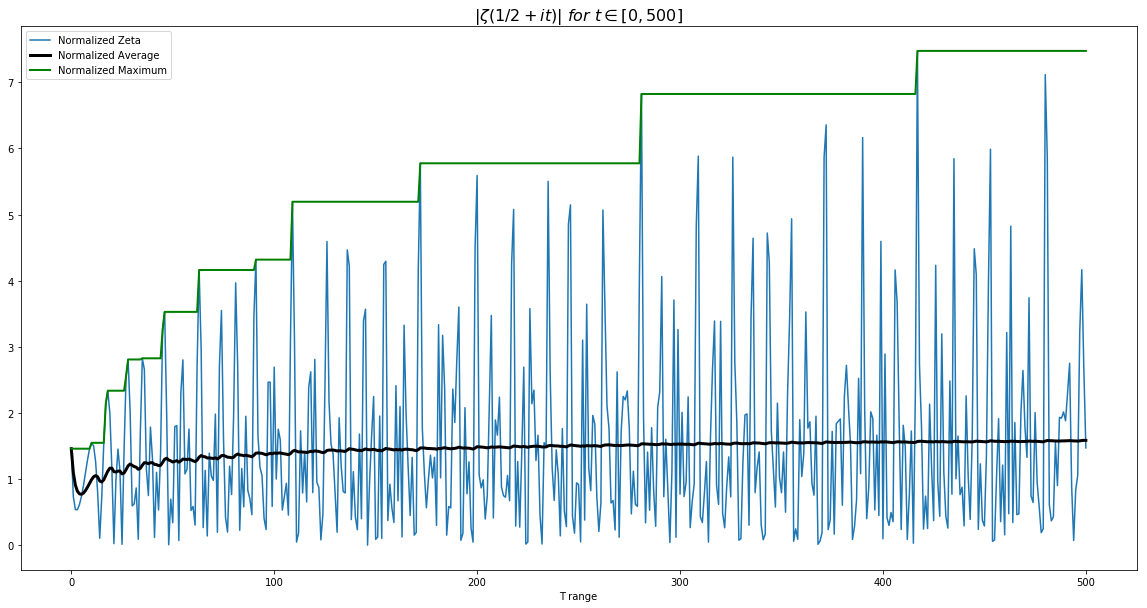

In [11]:
plt.figure(figsize=(20,10))  
plt.title('$|\zeta(1/2 + it)| \ for \ t\in [{},{}]$'.format(N, N+deltaN), size=16)
plt.plot(t_range, norm_zeta_value, label='Normalized Zeta')
plt.plot(t_range, average, label='Normalized Average', lw=3, color='black')
plt.plot(t_range, maximum, label='Normalized Maximum', lw=2, color='green')
plt.xlabel('T range')
plt.legend()
plt.show()

**Determing the average zeros for the optimal spacing**

We shall explore what should be considered the optimal spacing for the stochastic zeta function, by finding the best approximate for the average spacing between zeros on the interval for the log zeta norm function. We begin my estimating the zero's for the norm of the zeta function, which due to the construct of the norm never actually cross the zero axis into negative territory.

$$|\alpha+ i\beta| = \sqrt{\alpha^2+\beta^2} \geq 0; \ hence$$
$$|\zeta{1/2+ it}|\geq 0$$

In [12]:
interval_width = 10

In [13]:
logT_range = np.array([int(1e3), int(1e4), int(1e5), int(1e6)])

In [14]:
################################################
# Analyzing Zero's for the log Zeta norm function
################################################

def lzeroBehavior(t_range:np.array, interval_width:int = 10) -> np.array :
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param h: Provide a floating interval range to observe the Zeta function
    :param prime list: Provide an array of prime numbers
    :return: Returns a value for the stochastic Zeta function 
    """
    diff = np.array([0.0]*t_range.size)
    
    for t in range(0, t_range.size):
        
        epsilon = 0.005
        t_start = t_range[t]
        
        # creating the interval range t
        log_t_range = np.arange(t_start, t_start+interval_width, 0.1)

        # storage for the normal zeta 
        log_zeta_value = np.array([logZetaNorm(complex(real=0.5, imag=i)) for i in log_t_range])
        
        plt.figure(figsize=(15,5))
        plt.title('$log|\zeta(1/2 + it)| \ for \ t\in [{},{}]$'.format(t_start, t_start+interval_width), size=14)
        
        approx_zeros = []
        # computing the number of zero's defined by an epsilon bound
        for step in np.arange(t_start, t_start+interval_width, 0.001):
            curve_val = np.interp(step, log_t_range, log_zeta_value)
            
            # determine the zero's by an epsilon bound in abosulte value
            if (abs(curve_val) < epsilon):
                approx_zeros.append(step)
                plt.scatter(step, curve_val, color='black')
        
        plt.plot(log_t_range, log_zeta_value, label='Normalized Log Zeta')
        plt.plot(log_t_range, log_t_range*0, ls='--', color='orange')
        plt.legend()
        
        # computing the average across each scope (defined as the difference between x-points)
        scope = np.array(approx_zeros)[1:] - np.array(approx_zeros)[:-1]
        diff[t] = np.average(scope[abs(scope) >= 0.01])
        
    return diff

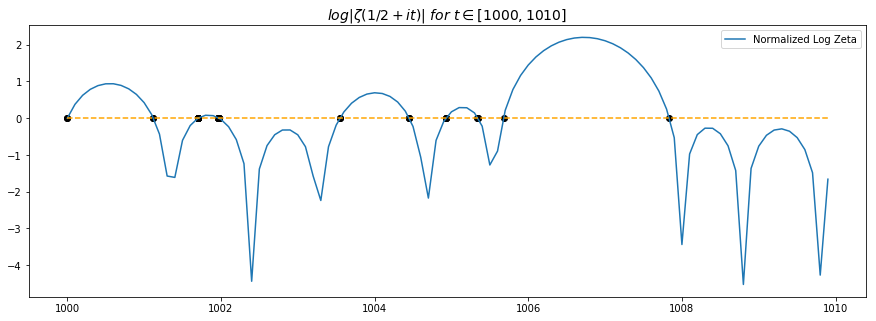

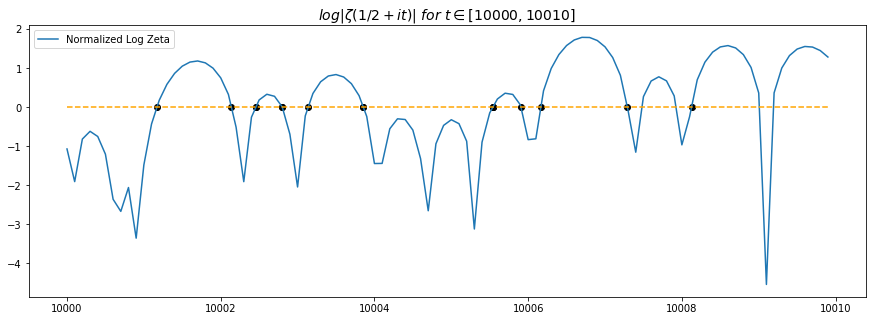

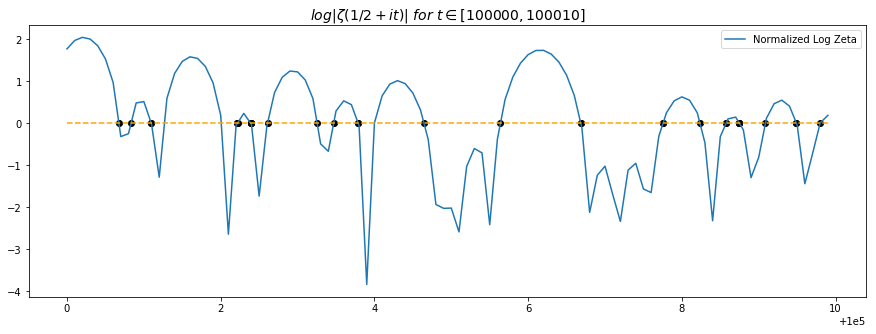

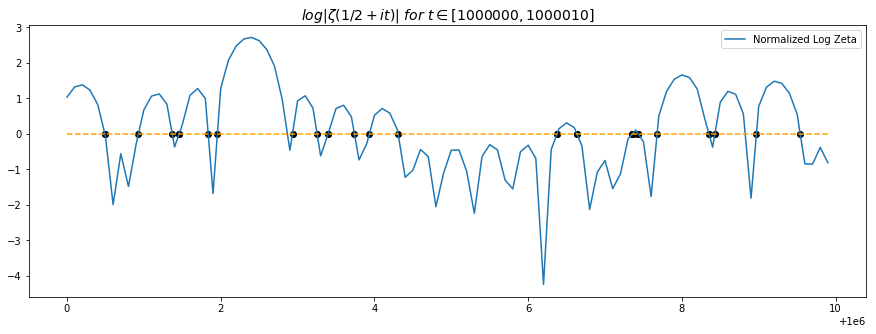

In [15]:
lzeroDiff = lzeroBehavior(logT_range)

In [16]:
################################################
# Analyzing Zero's for the Zeta norm function
################################################

def zzeroBehavior(t_range:np.array, interval_width:int = 10) -> np.array :
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param h: Provide a floating interval range to observe the Zeta function
    :param prime list: Provide an array of prime numbers
    :return: Returns a value for the stochastic Zeta function 
    """
    diff = np.array([0.0]*t_range.size)
    
    for t in range(0, t_range.size):
        
        epsilon = 0.2
        t_start = t_range[t]
        
        # creating the interval range t
        log_t_range = np.arange(t_start, t_start+interval_width, 0.1)

        # storage for the normal zeta 
        log_zeta_value = np.array([zetaNorm(complex(real=0.5, imag=i)) for i in log_t_range])
        
        plt.figure(figsize=(15,5))
        plt.title('$|\zeta(1/2 + it)| \ for \ t\in [{},{}]$'.format(t_start, t_start+interval_width), size=14)
        
        approx_zeros = []
        # computing the number of zero's defined by an epsilon bound
        for step in np.arange(t_start, t_start+interval_width, 0.001):
            curve_val = np.interp(step, log_t_range, log_zeta_value)
        
            # determine the zero's by an epsilon bound we approximate a wider value (near 0) since negatives aren't possible
            if (curve_val < epsilon):
                approx_zeros.append(step)
                plt.scatter(step, curve_val, color='black')
        
        plt.plot(log_t_range, log_zeta_value, label='Normalized Zeta')
        plt.plot(log_t_range, log_t_range*0, ls='--', color='orange')
        plt.legend()

        # computing the average across each scope (defined as the difference between x-points)
        scope = np.array(approx_zeros)[1:] - np.array(approx_zeros)[:-1]
        diff[t] = np.average(scope[abs(scope) >= 0.015])
        
    return diff

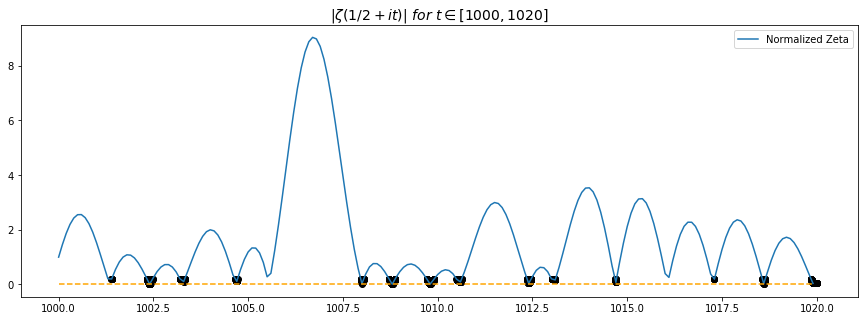

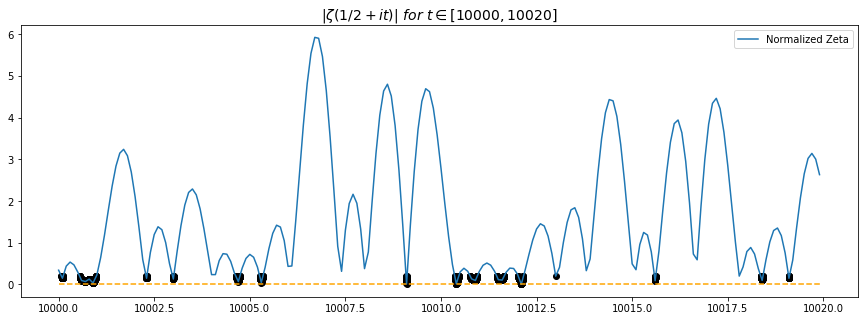

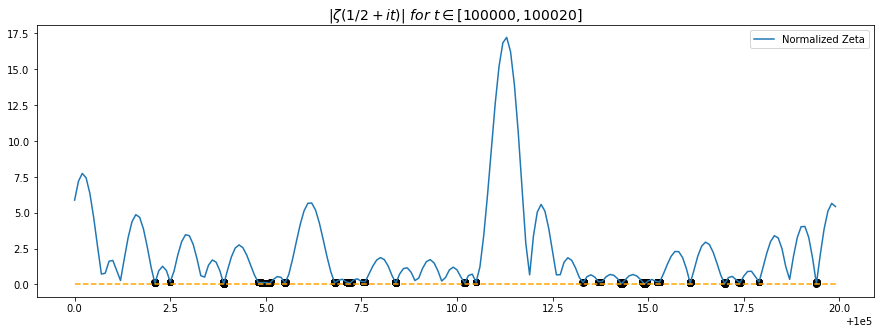

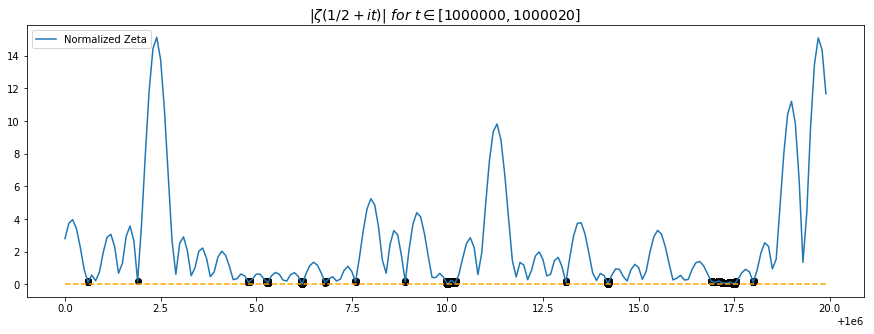

In [17]:
zzeroDiff = zzeroBehavior(logT_range, interval_width=20)

In [19]:
################################################
# Analyzing Zero's for the Stochastic Zeta norm function
################################################

def szeroBehavior(t_range:np.array, primes:np.array, interval_width:int = 2, increment:float = 0.01) -> np.array :
    """
    ACreates an array detailing the zero behaviro for the stochastic zeta function 
    :param t_range: Provide an array over the values of T to observe behavior 
    :param primes: Provide an array of prime numbers
    :param interval_width: Provide an even integer to define the width of the h-interval for the stochastic process
    :param increment: Provide a float to specify the step size of each point in the h-interval
    :return: Returns an array of the average difference between zeros 
    """
    assert (interval_width%2 == 0), "Interval width must be an even integer"
    diff = np.array([0.0]*t_range.size)
    
    for t in range(0, t_range.size):
        
        epsilon = 0.005
        t_start = t_range[t]
        
        # filtered prime list according to a given value T
        prime_list = primes[primes <= t_start]
        
        # define the h_range used for the stochastic process
        h_range = np.arange(-interval_width/2, interval_width/2, increment)

        # storage for the normal zeta 
        log_zeta_value = np.array([zetaStochastic(i, prime_list) for i in h_range])
        
        plt.figure(figsize=(15,5))
        plt.title('$log|\zeta(1/2 + it)| \ for \ h\in [{},{}] \ and \ t={}$'.format(-interval_width/2,interval_width/2, t_start), 
                  size=14)
        
        approx_zeros = []
        # computing the number of zero's defined by an epsilon bound
        for step in np.arange(-interval_width/2, interval_width/2, 0.001):
            curve_val = np.interp(step, h_range, log_zeta_value)
            
            # determine the zero's by an epsilon bound in abosulte value
            if (abs(curve_val) < epsilon):
                approx_zeros.append(step)
                plt.scatter(step, curve_val, color='black')
        
        plt.plot(h_range, log_zeta_value, label='Stochastic Log Zeta')
        plt.plot(h_range, h_range*0, ls='--', color='orange')
        plt.legend()
        
        # computing the average across each scope (defined as the difference between x-points)
        scope = np.array(approx_zeros)[1:] - np.array(approx_zeros)[:-1]
        diff[t] = np.average(scope[abs(scope) >= 0.01])
        
    return diff

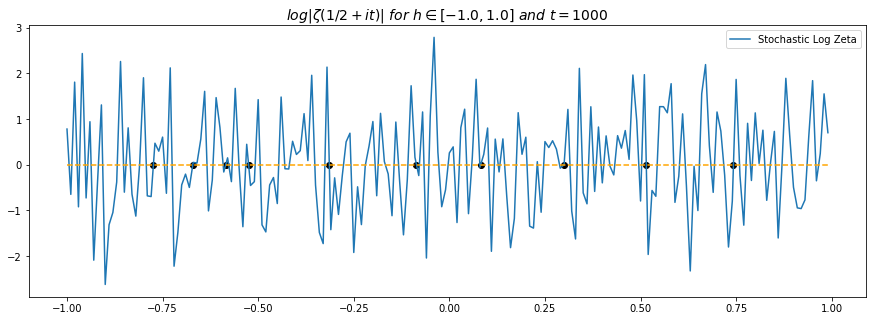

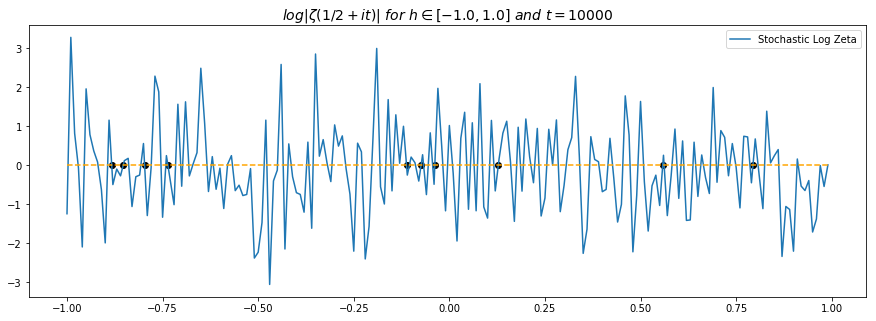

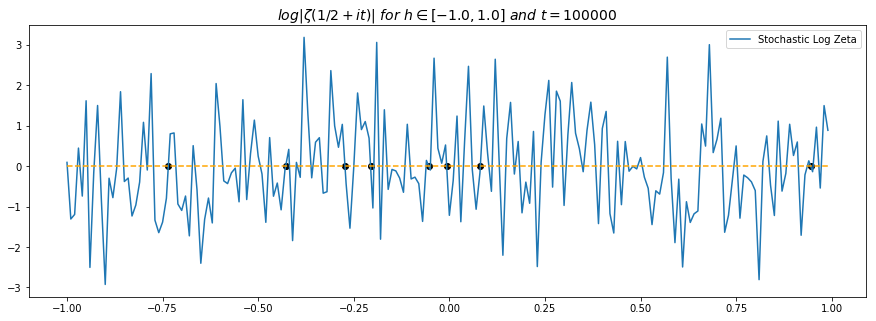

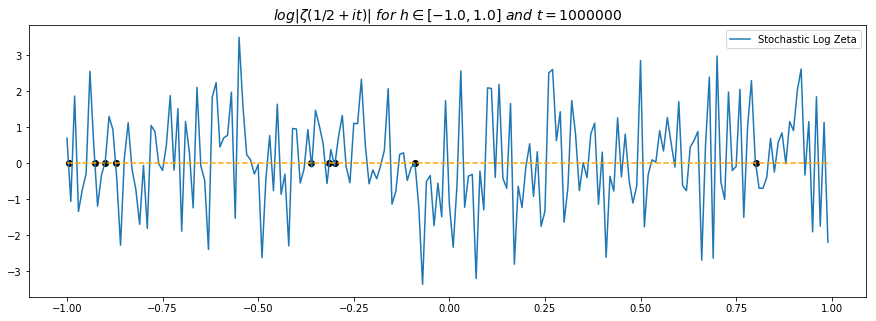

In [20]:
szeroDiff_01 = szeroBehavior(logT_range, prime_num, increment=0.01)

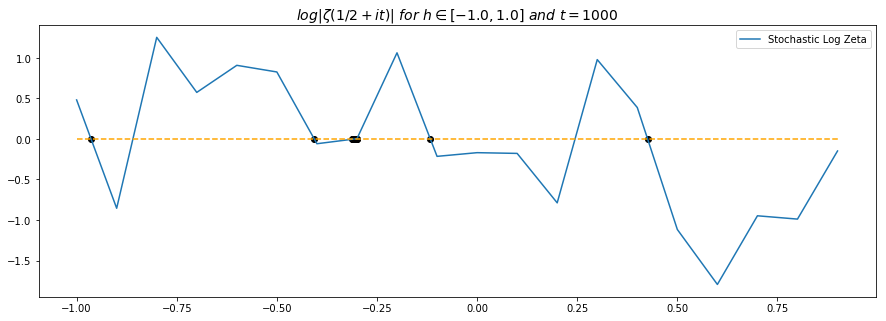

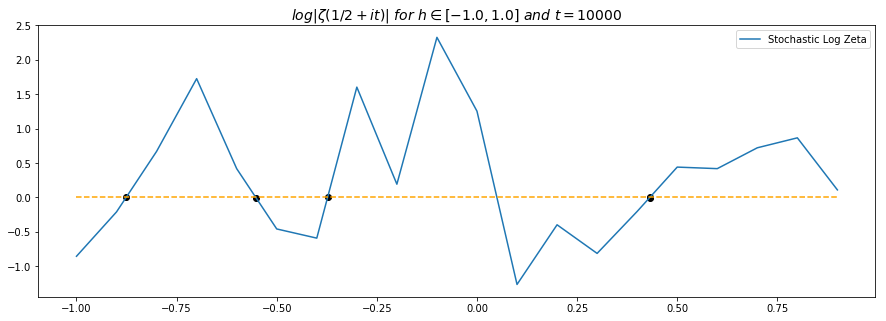

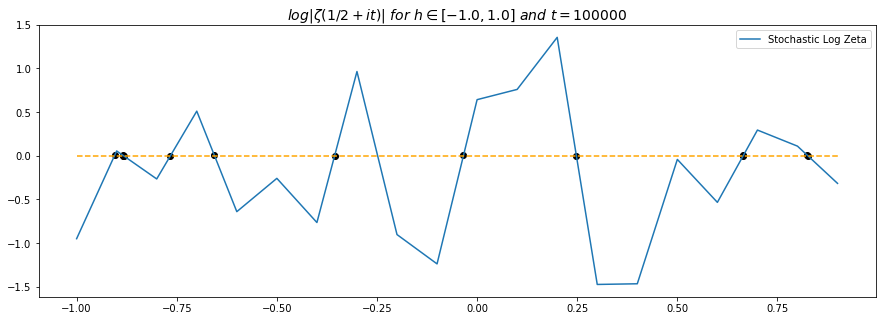

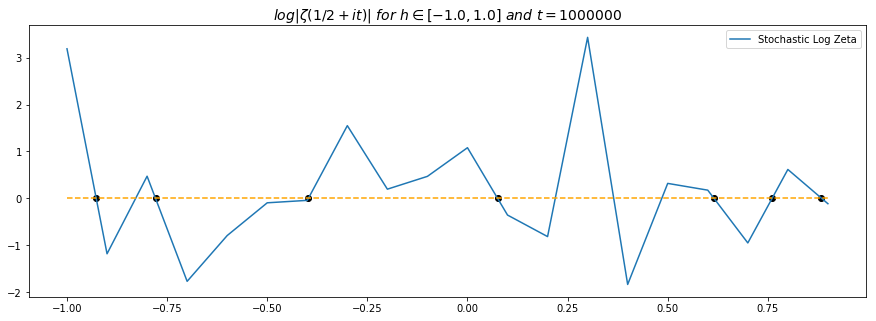

In [21]:
szeroDiff_10 = szeroBehavior(logT_range, prime_num, increment=0.10)

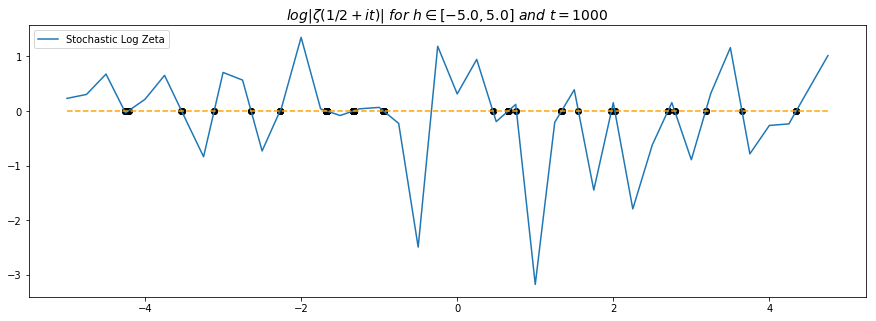

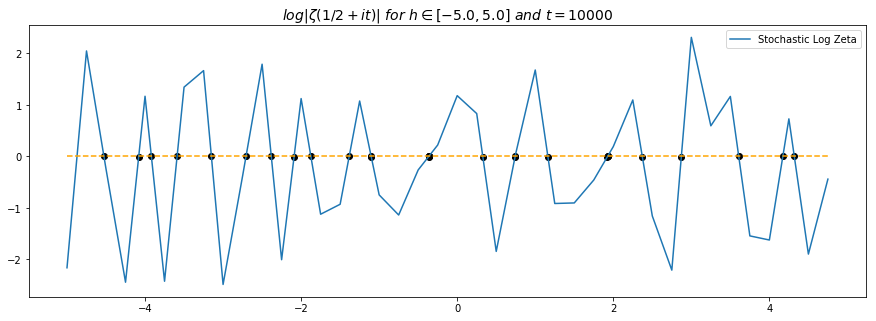

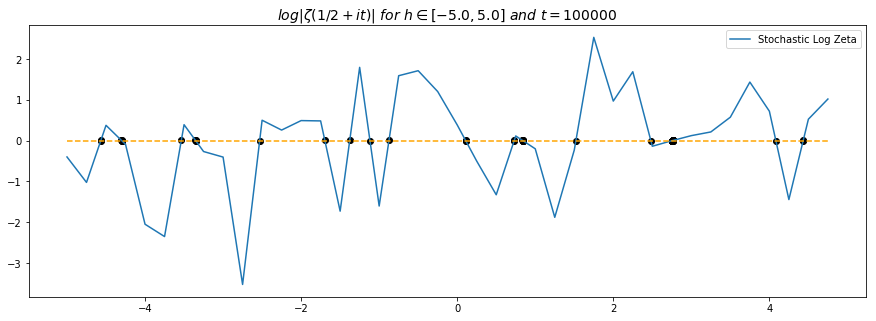

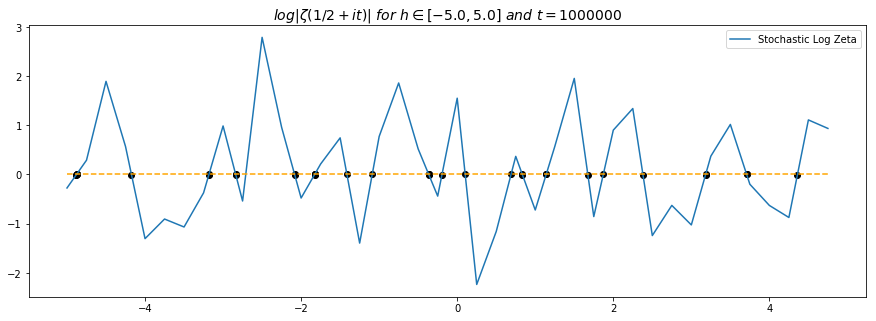

In [22]:
szeroDiff_25 = szeroBehavior(logT_range, prime_num, interval_width=10, increment=0.25)

**Analyzing the average distance between approximated zeros for Zeta functions**

In [23]:
# Our theoretical spacing requirements
a = pd.DataFrame(data=[(2*np.pi/np.log(i)) for i in logT_range], 
                 index=logT_range, columns=['Roots diff. using 2π/ln(T)'])
b = pd.DataFrame(data=[(1/np.log(i)) for i in logT_range], 
                 index=logT_range, columns=['Roots diff. using 1/ln(T)'])

# Our simulated spacing levels (zeta, log zeta, stochastic zeta)
c = pd.DataFrame(data=[i for i in zzeroDiff], 
                 index=logT_range, columns=['Roots diff. Zeta Sim'])
d = pd.DataFrame(data=[i for i in lzeroDiff], 
                 index=logT_range, columns=['Roots diff. Log Zeta Sim'])
e = pd.DataFrame(data=[i for i in szeroDiff_01], 
                 index=logT_range, columns=['Roots diff Stoch Zeta Sim 0.01'])
f = pd.DataFrame(data=[i for i in szeroDiff_10], 
                 index=logT_range, columns=['Roots diff Stoch Zeta Sim 0.10'])
g = pd.DataFrame(data=[i for i in szeroDiff_25], 
                 index=logT_range, columns=['Roots diff Stoch Zeta Sim 0.25'])

Our DataFrame below highlights the difference between zero roots using the spacing conventions $\frac{2\pi}{ln(T)}$ and $\frac{1}{ln(T)}$ with the simulated roots coming from the log zeta, stochastic zeta and regular zeta functions. Our values are computed via averaging all the zero differences present within a small interval.

In [24]:
a.join(b).join(c).join(d).join(e).join(f).join(g)

,Roots diff. using 2π/ln(T),Roots diff. using 1/ln(T),Roots diff. Zeta Sim,Roots diff. Log Zeta Sim,Roots diff Stoch Zeta Sim 0.01,Roots diff Stoch Zeta Sim 0.10,Roots diff Stoch Zeta Sim 0.25
1000,0.909584,0.144765,1.327385,0.867111,0.168556,0.344500,0.426050
10000,0.682188,0.108574,1.254786,0.695000,0.186333,0.435667,0.441850
100000,0.545751,0.086859,0.796750,0.506111,0.240000,0.215875,0.560188
1000000,0.454792,0.072382,1.158429,0.451800,0.224625,0.301833,0.485474


In [85]:
# sum of primes up to T^(1/3) - modify stochastic zeta to sum up to fractional power of T - modify the conjecture to sqrt T
# 

### Stochastic Zeta Large Value Conjectures

In [119]:
# value of T placed at 10^6 (consider investigating runtime with T - expect to be exponential for T)
T_val = int(1e6)

# create range interval of h from -1 to 1 (we use the optimal spacing convention calculated before) 
x=np.arange(-1,1,2*np.pi/np.round(np.log(T_val)))

In [120]:
x

array([-1.        , -0.60730092, -0.21460184,  0.17809725,  0.57079633,
        0.96349541])

**Runtime Complexity**

In [ ]:
# run time complexity of the stochastic zeta function as a function of T ~ numbers summed 
T_time = np.arange(2, 7)
T_complexity = []

# consider using parallel programming for calculation in zeta stochastic  
for t in T_time:
    start_time = default_timer()
    good_primes = prime_num[prime_num <= t]
    sample_t = np.arange(-1,1,2*np.pi/np.round(np.log(t)))
    
    [[zetaStochastic(h=i, prime_list=good_primes) for i in sample_t] for _ in range(10)]
    complexity.append(default_timer() - start_time)

In [121]:
# run time complexity of the stochastic zeta function as a function of N ~ # simulation
run_time = np.arange(1, 10, 2)
complexity = []

# consider using parallel programming for calculation in zeta stochastic  
for s in run_time:
    start_time = default_timer()
    good_primes = prime_num[prime_num <= T_val]
    [[zetaStochastic(h=i, prime_list=good_primes) for i in x] for _ in range(s)]
    complexity.append(default_timer() - start_time)

In [122]:
# preform regression on the runtime of the stochastic zeta function
comp_reg_slope = linregress(run_time, complexity).slope 
comp_reg_intercept = linregress(run_time, complexity).intercept 

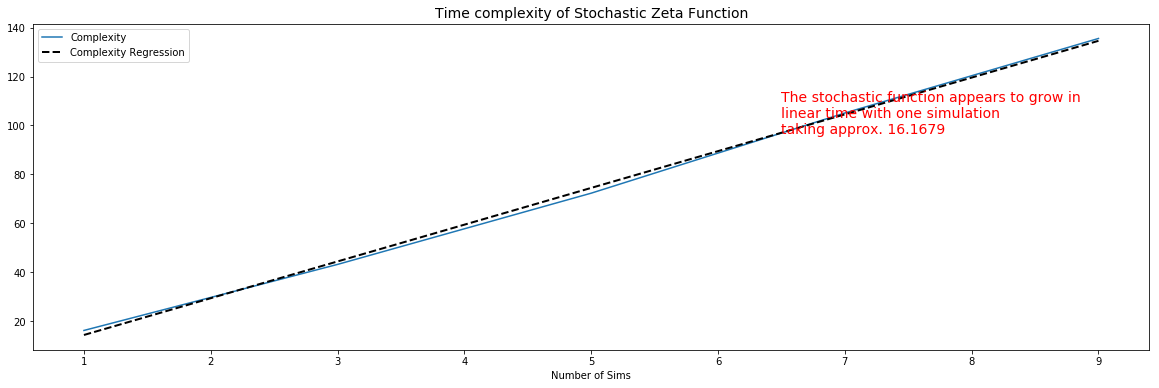

In [123]:
plt.figure(figsize=(20,6))  
plt.title("Time complexity of Stochastic Zeta Function", size=14)
plt.plot(run_time, complexity, label='Complexity')
plt.plot(run_time, [comp_reg_slope*i + comp_reg_intercept for i in range(1,10, 2)], label='Complexity Regression', 
         ls='--', lw=2, color='black')
plt.text(6.5, comp_reg_slope*6.5 - 1, 
         'The stochastic function appears to grow in \nlinear time with one simulation\ntaking approx. {}'.format(round(complexity[0], 4)), 
         size=14, color='red')
plt.xlabel('Number of Sims')
plt.legend()
plt.show()

In [124]:
# create stochastic zeta range over h interval 
sims = 100
good_primes = prime_num[prime_num <= T_val]
y = np.array([[zetaStochastic(h=i, prime_list=good_primes) for i in x] for _ in range(sims)]).reshape(sims, x.size)

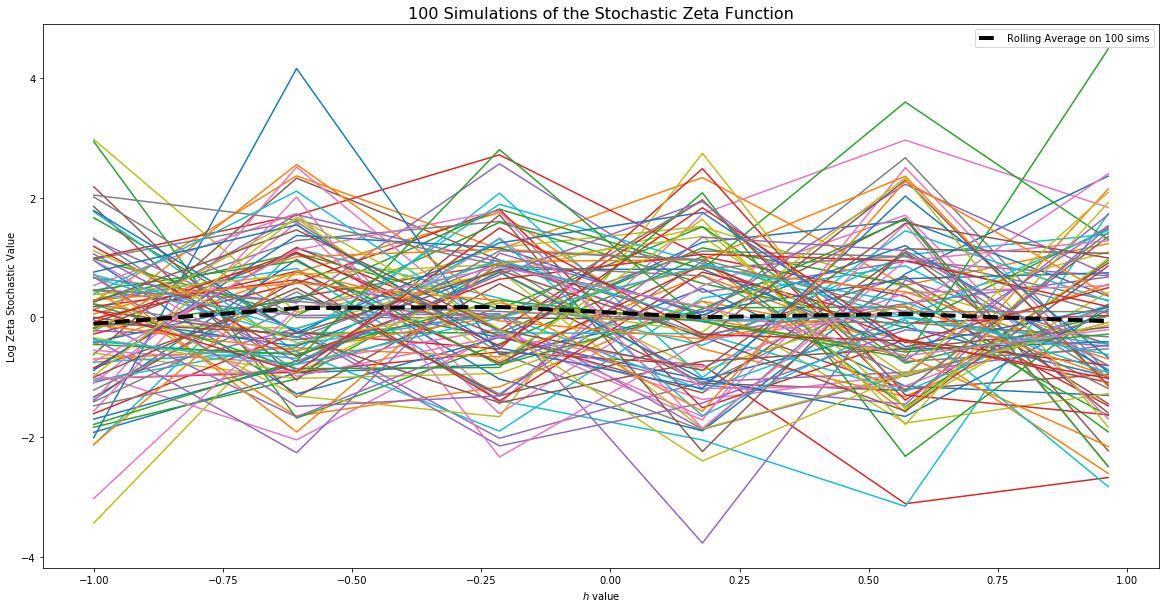

In [125]:
plt.figure(figsize=(20,10))  
plt.title("100 Simulations of the Stochastic Zeta Function", size=16)
for i in y:
    plt.plot(x, i)
plt.plot(x, np.average(y, axis=0), lw=4, color='black', label='Rolling Average on {} sims'.format(sims), ls='--')

plt.ylabel('Log Zeta Stochastic Value')
plt.xlabel('$h$ value')
plt.legend()
plt.show()

**Conjecture**

We assert that the maxium of the stochastic function should be defined as follows:
$$max_{|h|<1}X_t(h)\approx log(log(T)) - \frac{3}{4}log(log(log(T)))$$
Abbreviating the log expressions, we underscore each log with the number of succesive logs taken of the value $T$ below
$$max_{|h|<1}X_t(h)\approx log_2(T)) - \frac{3}{4}log_3(T)))$$
I shall also be exploring the IID instance, where our conjecture converges to the following: 
$$max_{|h|<1}X_t(h)\approx log_2(T)) - \frac{1}{4}log_3(T)))$$

In [126]:
# computes the max of the stochastic zeta function 
stoch_max = lambda x: (np.log(np.log(x)) - 0.75*np.log(np.log(np.log(x))))
stoch_max_iid = lambda x: (np.log(np.log(x)) - 0.25*np.log(np.log(np.log(x))))

In [128]:
cong_stoch_max = stoch_max(T_val)
cong_stoch_max_iid = stoch_max_iid(T_val)

print("Our simulated maximum was        ->", np.average(y.max(axis=1)))
print("Conjecture maximum should be     ->", cong_stoch_max)
print("IID Conjecture maximum should be ->", cong_stoch_max_iid)

# when using the interval spacing of 2π/log(T) our simulated maximum tends to look more like the FHK conj.
# when using the interval spacing of 1/log(T) our simulated maximum tends to look more like the IID conj.

Our simulated maximum was        -> 1.605506822111242
Conjecture maximum should be     -> 2.0131198858346617
IID Conjecture maximum should be -> 2.524335024813733


In [ ]:
# At 10^6 value for T
# Our simulated maximum was        -> 1.4262728005084917
# Conjecture maximum should be     -> 1.901755015287042
# IID Conjecture maximum should be -> 2.3844462814130214

# At 10^7 value for T
# Our simulated maximum was        -> 1.605506822111242
# Conjecture maximum should be     -> 2.0131198858346617
# IID Conjecture maximum should be -> 2.524335024813733

**Function Variation and Theoretical Error**

To measure the degree of variation expected with the simulation for large values of Zeta, we need to consider extreme statistics for determining the extent of our model's variation. We begin by recentering our stochastic model as follows: 
$$\Theta = max_{|h|<1}X_t(h) - (log_2(T) - \frac{3}{4}log_3(T))$$
We say that our $\Theta$ follows a [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution), defined below
$$P(\Theta < x)=exp(-e^\frac{-(x-\mu)}{\beta})$$ 
$$P(\Theta < x)=exp(-ce^{-2x}) \, \ \ \  \mu = 0 \ , \ \ \beta = \frac{1}{2}$$ 

Our variance measure is then:
$$Var(\Theta)=\frac{\pi^2}{6}\beta^2=\frac{\pi^2}{24}\approx 0.41123$$

Hence, in our case our expression for the maximum of our stochastic process introduces and error term: 
$$\Theta = max_{|h|<1}X_t(h) - [log_2(T) - \frac{3}{4}log_3(T)] = Gumbel\sim(0, \frac{\pi^2}{24})$$
We will examine this realization to check whether our empirical data shows evidence of a Gumbell distribution of order described above

In [34]:
# incremental steps in time T
T_stamps = [int(1e3), int(1e4), int(1e5), int(1e6)]

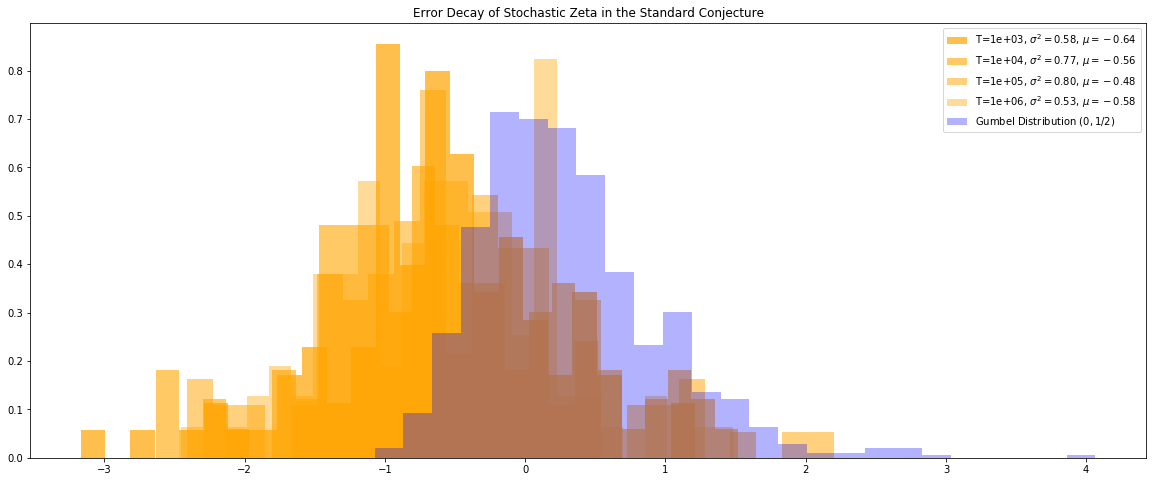

In [35]:
bins = 25
a_term = 0.7

# gumbel distribution with mean 0 and beta 0.5, variance 0.41
gumbel_dist = gumbel_r.rvs(loc=0, scale=0.5, size=1000)

plt.figure(figsize=(20, 8))
plt.title('Error Decay of Stochastic Zeta in the Standard Conjecture')

# changes in T over time from 10^3 - 10^6
for t in T_stamps:
    # prime list filtering via T
    good_primes = prime_num[prime_num <= t]
    
    # create range interval of h from -1 to 1 (points at every 2π/log(T)) - need to re-run
    H=np.arange(-1,1,2*np.pi/np.round(np.log(t)))
    
    temp = np.array([[zetaStochastic(h=i, prime_list=good_primes) for i in H] for _ in range(sims)]).reshape(sims, H.size)
    error = (temp.max(axis=1) - stoch_max(t))
    
    # computing the variance and average of the function 
    cVar = np.var(error)
    average = np.average(error)
    
    # re-centered normal distrubtion to observe the shape of the hist (variance pi^2/24)
    plt.hist(error, bins=bins, alpha=a_term, color='orange', density=True, 
             label="T={}, $\sigma^2={}$, $\mu={}$".format(('%.0e' % t), ('%.2f' % cVar), ('%0.2f' % average)))
    a_term -= 0.1

plt.hist(gumbel_dist, bins=bins, alpha=0.3, color='blue', 
         label="Gumbel Distribution $(0,1/2)$", density=True)
plt.legend()
plt.show()

Analyzing the distribution of the stochastic model error, defined as our approximated model maximum minus our theoretical value  
$$\hat{max}_{|h|<1}X_t(h) - max_{|h|<1}X_t(h)$$
We see that the error measure for the $3/4$ conjecture doesn't quite follow the outline of a Gumbel distribution with variance $\frac{\pi^2}{24}$, for small values of $T$ (e.g. $10^6$) having intervals of sustained error exceeding a relative error of 60%. This issue might be rectified, however, as $T\rightarrow \infty$.   

In [36]:
time_range = np.array([int(1e3), int(1e4), int(1e5), int(1e6), int(1e7)])

In [44]:
error_arr = []

# examine the error decay from projected to theoretical as T grows 
for t in time_range:
    # filtered prime list 
    good_primes = prime_num[prime_num <= t]
    
    # create range interval of h from -1 to 1 (points at every 2π/log(T)) - need to re-run
    h_range = np.arange(-1,1,2*np.pi/np.round(np.log(t)))

    temp_arr = np.array([[zetaStochastic(h=i, prime_list=good_primes) for i in h_range] for _ in range(50)])
 
    # compute the error term for the given value of T - aboslute error average 
    e_term = np.average(abs(temp_arr.max(axis=1) - stoch_max(t))) / stoch_max(t)
    error_arr.append(e_term)

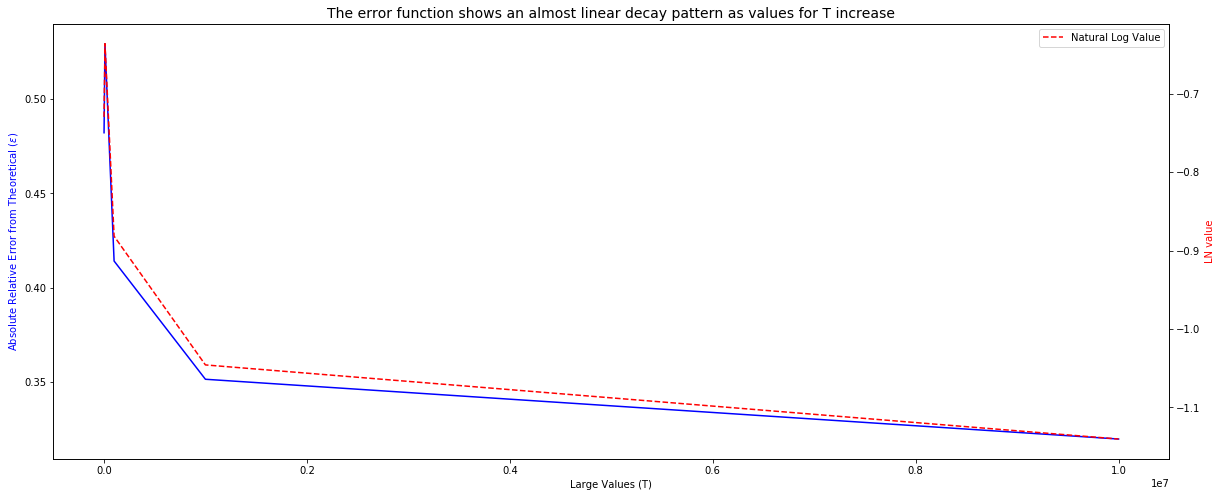

In [45]:
fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(20)

ax1.set_xlabel('Large Values (T)')
ax1.set_ylabel('Absolute Relative Error from Theoretical ($\epsilon$)', color='blue')
ax1.plot(time_range, error_arr, label='Error Decay', color='blue')

ax2 = ax1.twinx() 

ax2.plot(time_range, np.log(error_arr), color='red', label='Natural Log Value', ls='--')
ax2.set_ylabel('LN value', color='red')

plt.title("The error function shows an almost linear decay pattern as values for T increase", size=14)

plt.legend()
plt.show()

Taking our log of the error term, we can determine the approximate value of $T$ such that our relative error is bounded by $0.05$. This follows as such:
$$\epsilon = \frac{(\hat{max}_{|h|<1}X_t(h) - max_{|h|<1}X_t(h))}{max_{|h|<1}X_t(h)}$$
We take that as $T$ increases we can take the natural log of the error function to be a proxy for the error decay rate. Hence, to find a appropriate value $T$ for the bounded $0.05$ condition we simply solve the expression below:

$$ln(0.05)=x\Rightarrow x\approx-3$$

By simple extrapolation we have that at $\approx 10^{12}$ our relative error defined by $\epsilon$ above should converge to $\approx 0.05$. I show this relationship below, highlighting the linear relationship between the rise in $x$ and the fall in the natural log.  

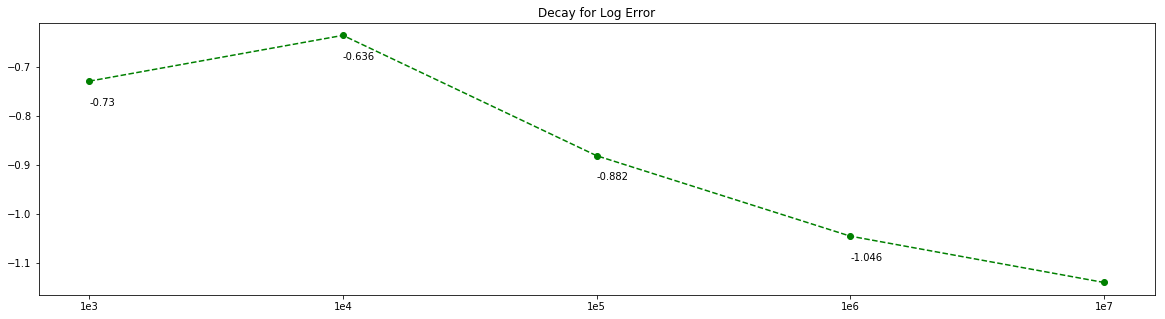

In [53]:
plt.figure(figsize=(20,5))
plt.title('Decay for Log Error')
# plt.text(2.0,-0.7,
#          s='It appears the log function decreases by an approx. factor of \n$0.3$ for every increase in power $x$ for $10^x$ where $x > 3$',  
#          size=15)
plt.plot(['1e3', '1e4', '1e5', '1e6', '1e7'], np.log(error_arr), color='green',  marker='o', ls='--')

# report the values at each assigned power
for i in range(4):
    plt.text(i,np.log(error_arr)[i]-0.05,round(np.log(error_arr)[i], 3))
plt.show()

For the **IID case** we have that,
$$\Theta = max_{|h|<1}X_t(h) - (log_2(T) - \frac{1}{4}log_3(T)) = Gumbel\sim(0,\frac{1}{2})$$
With error term confined to the Gumbell distribution, with mean $0$ and variance $1/2$. Hence, we take our $\beta$ parameter to be equal to $\frac{\sqrt{3}}{\pi}$. We examine the error distribution in similar fashion as we did with the non-IID case. It appears that the distrubtion's closely centered with minior variations in skew.  

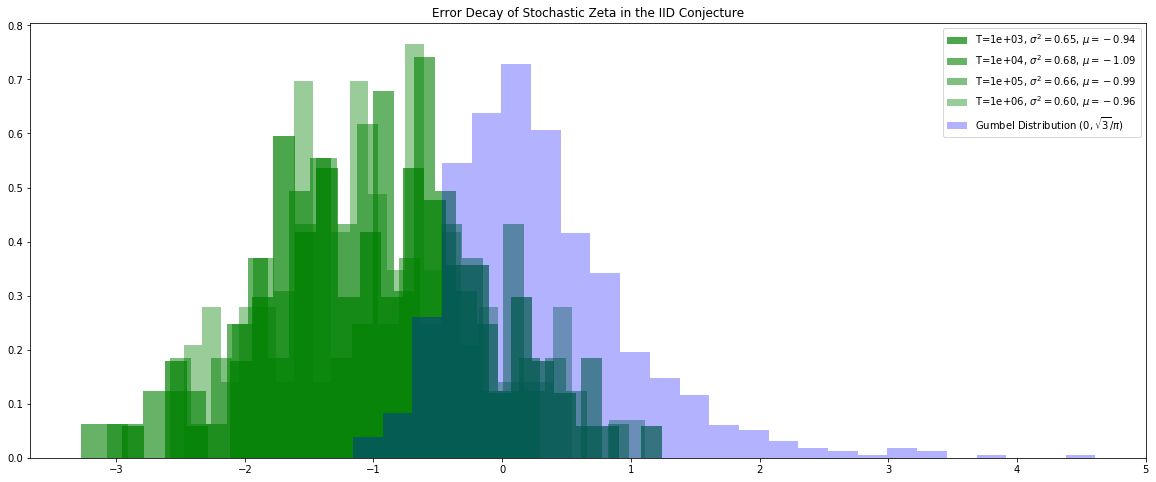

In [47]:
bins = 25
a_term = 0.7

# gumbel distribution with mean 0 and beta 0.5
iid_gumbel_dist = gumbel_r.rvs(loc=0, scale=np.sqrt(3)/np.pi, size=1000)

plt.figure(figsize=(20, 8))
plt.title('Error Decay of Stochastic Zeta in the IID Conjecture')

# changes in T over time from 10^3 - 10^6
for t in T_stamps:
    # filtering primes 
    good_primes = prime_num[prime_num <= t]
    
    # create range interval of h from -1 to 1 (points at every 2π/log(T)) - need to re-run
    H=np.arange(-1,1,2*np.pi/np.round(np.log(t)))
    
    iid_temp = np.array([[zetaStochastic(h=i, prime_list=good_primes) for i in H] for _ in range(sims)]).reshape(sims, H.size)
    iid_error = (iid_temp.max(axis=1) - stoch_max_iid(t))

    # computing the variance and average of the function 
    iid_cVar = np.var(iid_error)
    iid_average = np.average(iid_error)

    # re-centered normal distrubtion to observe the shape of the hist (variance pi^2/24)
    plt.hist(iid_error, bins=bins, alpha=a_term, color='green', density=True, 
             label="T={}, $\sigma^2={}$, $\mu={}$".format(('%.0e' % t), ('%.2f' % iid_cVar), ('%.2f' % iid_average)))
    a_term -= 0.1
    
plt.hist(iid_gumbel_dist, bins=bins, alpha=0.3, color='blue', 
         label="Gumbel Distribution $(0,\sqrt{3}/\pi)$", density=True)
plt.legend()
plt.show()

Given the skew present above, we will look to further exmaine a method of defining the statisical significance of the $c$ parameters $3/4$ and $1/4$ respecitively. We begin by examining the qoutient of values for both conjectures as $T$ increases, this is defined as follows: 

$$\Lambda_1 = \frac{(log_2(T) - \frac{3}{4}log_3(T))}{\hat{max}_{|h|<1}X_t(h)} \ \ \ \ \ \  \Lambda_2 = \frac{(log_2(T) - \frac{1}{4}log_3(T))}{\hat{max}_{|h|<1}X_t(h)}$$

In [48]:
stochastic_dict = {"FHK Error (3/4)" : [], "IID Error (1/4)" : []}

# changes in T over time from 10^3 - 10^6
for t in T_stamps:
    # simulate the temporary prime list
    sample_primes = prime_num[prime_num <= t]
    
    # create range interval of h from -1 to 1 (points at every 2π/log(T)) - need to re-run
    X=np.arange(-1,1,2*np.pi/np.round(np.log(t)))
    
    # generate the stochastic zeta funciton 
    temp_value = np.array([[zetaStochastic(h=i, prime_list=sample_primes) for i in X] for _ in range(sims)]).reshape(sims, X.size)
    
    # generate the simulated maximum taking the average of the maxium of the paths 
    sim_max = np.average(temp_value.max(axis=1))
    
    # compute each error term 
    error1 = ( stoch_max(t) / sim_max )
    error2 = ( stoch_max_iid(t) / sim_max)
    
    # append to the dictionary 
    stochastic_dict['FHK Error (3/4)'].append(error1)
    stochastic_dict['IID Error (1/4)'].append(error2)


In [49]:
# DataFrame of stochastic error expression 
print(pd.DataFrame(data=stochastic_dict, index=['1e3', '1e4', '1e5', '1e6']))

     FHK Error (3/4)  IID Error (1/4)
1e3         1.657524         2.037135
1e4         2.067797         2.576212
1e5         1.404159         1.757857
1e6         1.337015         1.676367


**Hyper-Parameter Estimate (Scaling Coefficients)**

It becomes quite apparent that distinguishing the significance between the FHK conjecture with coefficient $3/4$ and our IID conjecture with coefficient $1/4$ is not very rigourous. As we have assumed both coefficients are accurate in our expression, we shall take the following: 

$$\hat{max}_{|h|<1}X_t(h)\approx \gamma_1log_2(T) - \gamma_2log_3(T) + \Delta$$

Where our parameters $\gamma_1, \gamma_2$ are defined as follows:

$$\gamma_1 \approx \frac{\hat{max}_{|h|<1}X_t(h)}{log_2(T)} \ \ \ \ \ \gamma_1 \approx \frac{\hat{max}_{|h|<1}X_t(h) - log_2(T)}{log_3(T)}$$

In [55]:
paramT = [int(1e3), int(1e4), int(1e5), int(1e6)]

In [56]:
gamma1_parameter_dict = {int(1e3):[], int(1e4):[], int(1e5):[], int(1e6):[]}
gamma2_parameter_dict = {int(1e3):[], int(1e4):[], int(1e5):[], int(1e6):[]}

# changes in T over time from 10^3 - 10^6
for t in paramT:
    # simulate the temporary prime list
    sample_primes = prime_num[prime_num <= t]
    
    # create range interval of h from -1 to 1 (points at every 2π/log(T)) - need to re-run
    V=np.arange(-1,1,2*np.pi/np.round(np.log(t)))
    
    # generate the stochastic zeta funciton 
    temp_value = np.array([[zetaStochastic(h=i, prime_list=sample_primes) for i in V] for _ in range(sims)]).reshape(sims, V.size)
    log2T = log(log(t))
    log3T = log(log2T)
    
    # generate the gamma component as an array modified by the log scalar 
    
    # gamma 1 go to 1 - 3/4*log3T/log2T
    gamma_1 = temp_value.max(axis=1) / log2T
    gamma_2 = (temp_value.max(axis=1) - log2T) / log3T
    
    # compute each error term 
    gamma1_parameter_dict[t] = gamma_1
    gamma2_parameter_dict[t] = gamma_2

In [57]:
# creating the gamma dataframes for parameter 1 and 2
df1 = pd.DataFrame(data=gamma1_parameter_dict)
df2 = pd.DataFrame(data=gamma2_parameter_dict)

In [67]:
df1.head()

,1000,10000,100000,1000000
0,0.069144,-0.091152,0.710149,0.638237
1,0.023654,0.743333,0.580041,0.529657
2,-0.186415,0.647835,0.710946,0.916907
3,1.214480,-0.002528,0.586612,-0.043461
4,0.030405,0.382454,0.532078,0.188377


In [59]:
# gamma dataframes re-organzied to include the T values 
gamma1_df = pd.DataFrame(pd.concat([df1[1000], df1[10000], df1[100000], df1[1000000]]), 
                         columns=['Gamma1'])
gamma1_df['T'] = [t for t in np.arange(4) for i in range(100)]

gamma2_df = pd.DataFrame(pd.concat([df2[1000], df2[10000], df2[100000], df2[1000000]]), 
                         columns=['Gamma2'])
gamma2_df['T'] = [t for t in np.arange(4) for i in range(100)]

In [60]:
# linear sklearn linear regression model and predicting over the range 
gamma1_model = LinearRegression().fit(gamma1_df['T'].values.reshape(-1,1), gamma1_df['Gamma1'].values)
gamma1_linear = gamma1_model.predict(gamma1_df['T'].values.reshape(-1,1))

gamma2_model = LinearRegression().fit(gamma2_df['T'].values.reshape(-1,1), gamma2_df['Gamma2'].values)
gamma2_linear = gamma2_model.predict(gamma2_df['T'].values.reshape(-1,1))

In [61]:
x_Taxis = np.array([['1e3']*100, ['1e4']*100, ['1e5']*100, ['1e6']*100])
T_range_str = ['1e3', '1e4', '1e5', '1e6']

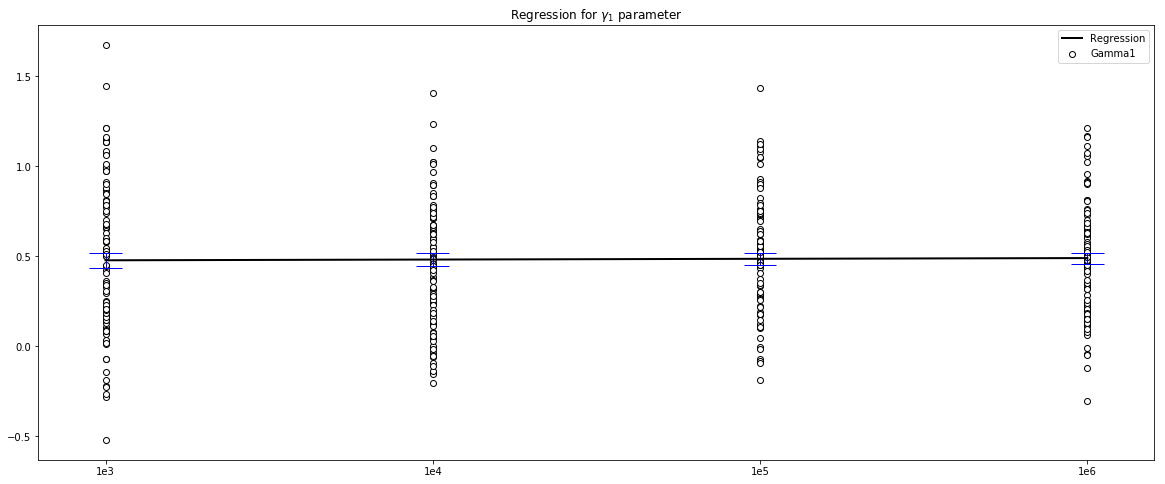

In [62]:
# gamma 1 regression 
plt.figure(figsize=(20,8))
plt.title("Regression for $\gamma_1$ parameter")

# linear regression on stacked points 
plt.plot(x_Taxis.flatten(), 
         gamma1_linear, lw=2, color='black', label='Regression')

# determing the standard error per point 
for t in range(4):
    # compute the standard error defined the σ / sqrt(n)
    std_error = np.sqrt(np.var(df1[paramT[t]])) / 10 
    mu = gamma1_linear[100*t]
    
    # drawing the error bars 
    plt.vlines(T_range_str[t], mu - std_error, mu + std_error, colors='blue', lw=1)
    plt.hlines(mu + std_error, t-0.05, t+0.05,colors='blue', lw=1)
    plt.hlines(mu - std_error, t-0.05, t+0.05, colors='blue', lw=1)

# drawing of sample points
plt.scatter(x_Taxis.flatten(), 
            gamma1_df['Gamma1'], 
            marker='o', color='white', edgecolors='black')

plt.legend()
plt.show()

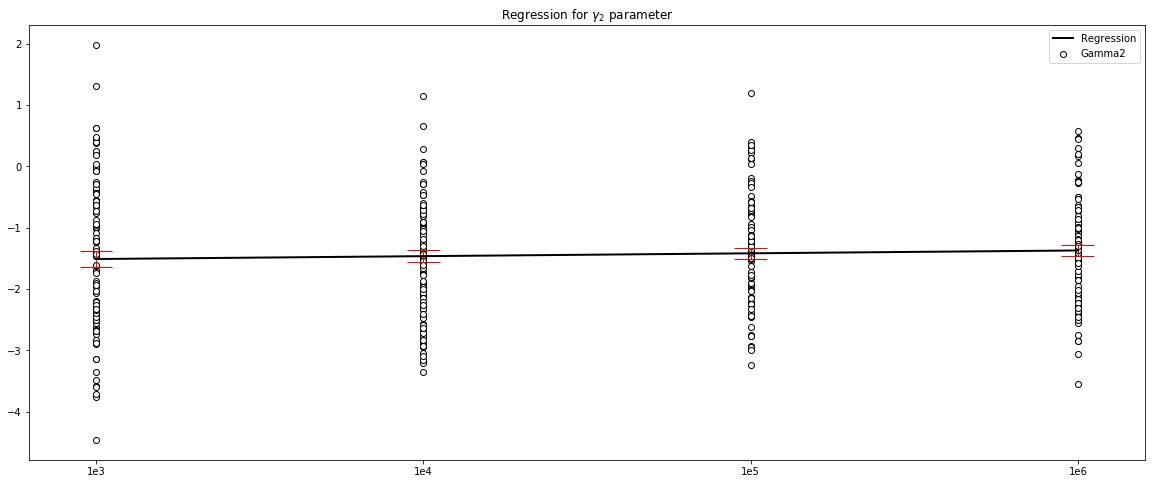

In [63]:
# gamma 2 regression
plt.figure(figsize=(20,8))
plt.title("Regression for $\gamma_2$ parameter")

# linear regression on stacked points 
plt.plot(x_Taxis.flatten(), 
         gamma2_linear, lw=2, color='black', label='Regression')

for t in range(4):
    # compute the standard error defined the σ / sqrt(n)
    std_error = np.std(df2[paramT[t]]) / 10
    mu = gamma2_linear[100*t]
    
    # drawing the error bars 
    plt.vlines(T_range_str[t], mu - std_error, mu + std_error, colors='red', lw=1)
    plt.hlines(mu + std_error, t-0.05, t+0.05,colors='red', lw=1)
    plt.hlines(mu - std_error, t-0.05, t+0.05, colors='red', lw=1)
    
# drawing of sample points
plt.scatter(np.array([['1e3']*100, ['1e4']*100, ['1e5']*100, ['1e6']*100]).flatten(), 
            gamma2_df['Gamma2'], 
            marker='o', color='white', edgecolors='black')

plt.legend()
plt.show()

In [64]:
print('Our gamma1 component is {}\nOur gamma2 component is {}'.format((('%.2f') % np.average(gamma1_df['Gamma1'])), 
                                                                      (('%.2f') % np.average(gamma2_df['Gamma2'])))) 

Our gamma1 component is 0.48
Our gamma2 component is -1.44


This again is not incredibly useful, as we have assumed that each gamma here is mutually exclusive and paramters do not share an underlying relationship that affects the overal behavior of the stochastic zeta maximum estimate. As such we take the joint regression fit over the independent variable $\frac{log_3T}{log_2T}$:
$$\frac{maxX_t}{log_2T} = \gamma_1 - \gamma_2 \frac{log_3T}{log_2T}$$

In [70]:
def linearParam(prime_num: np.array, t:int, sims:int=100) -> tuple:
    """
    Linear parameter fit for (x,y) coordinates 
    """
    # simulate the temporary prime list
    sample_primes = prime_num[prime_num <= t]
    
    # create range interval of h from -1 to 1 (points at every 2π/log(T)) - need to re-run
    H_range = np.arange(-1, 1, 2*np.pi/round(log(t)))
    
    # generate the stochastic zeta function 
    temp_value = np.array([[zetaStochastic(h=i, prime_list=sample_primes) for i in H_range] for _ in range(sims)])
    
    log2T = log(log(t))
    log3T = log(log2T)
    max_tempV = np.average(temp_value.max(axis=1))
    
    # compute the terms of our tuple expression
    yVal = max_tempV / log2T
    xVal = log3T/ log2T
    
    return (xVal, yVal)

In [129]:
arr = np.array([linearParam(prime_num=prime_num, t=T) for T in [int(1e3), int(1e4), int(1e5), int(1e6), int(1e7)]])

In [131]:
# preform regression on the runtime of the stochastic zeta function
joint_gamma2 = linregress(x=arr[:,0], y=arr[:,1]).slope 
joint_gamma1 = linregress(x=arr[:,0], y=arr[:,1]).intercept 

In [132]:
joint_gamma1, joint_gamma2

(-0.6854537190125337, 3.275554805529168)

In [133]:
reg_plot = [i*joint_gamma2 + joint_gamma1 for i in arr[:,0]]

In [139]:
np.array(reg_plot)

array([0.43126902, 0.49129228, 0.51220513, 0.51881665, 0.51925692])

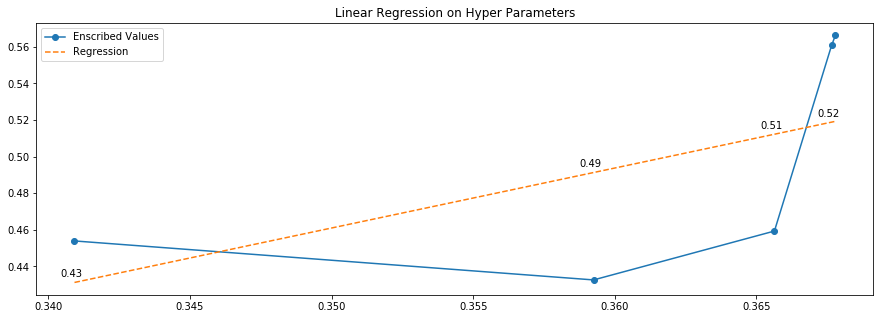

In [140]:
plt.figure(figsize=(15,5))
plt.title('Linear Regression on Hyper Parameters')
plt.plot(arr[:,0], arr[:,1], label='Enscribed Values', marker='o')
plt.plot(arr[:,0], reg_plot, label='Regression', ls='--')
for i in range(len(arr[:, 0])-1):
    plt.text(arr[i, 0]-0.0005, reg_plot[i]+0.003, round(reg_plot[i], 2))
plt.legend()
plt.show()

In [135]:
1-0.75*np.log(np.log(np.log(int(1e6))))/np.log(np.log(int(1e6)))

0.7242596051890677

In [136]:
1-0.25*np.log(np.log(np.log(int(1e6))))/np.log(np.log(int(1e6)))

0.9080865350630226

---

### Fyodorov-Hiary-Keating Conjecture

**Conjecture (Fyodorov-Hiary-Keating '12)**

if $\tau\sim Unif(T,2T)$, then as $T \rightarrow \infty$
$$max_{|h|<1}|\zeta(1/2 + i(\tau +h))| = \frac{log(T)}{log_2(T)^{3/4}}\cdot e^{M_t}$$
Where $M_t \rightarrow M$ in distribution and $P(M>y)\sim Cye^{-2y}$

**IID Heuristics predicts**
$$max_{|h|<1}|\zeta(1/2 + i(\tau +h))| = \frac{log(T)}{log_2(T)^{1/4}}\cdot e^{Gumbell}$$


In [32]:
%%cython
cimport numpy as nc

from mpmath import zeta
from random import uniform

def zetaUniformNorm(int T, int h) -> double:
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param N: Provide a number (presumably large) to start computing values for
    :param deltaN: Provide an integer number to cap off the consecutive sums of prime
    :return: Returns an array of the normalized values for Zeta 
    """
    cdef nc.complex128_t point = complex(0, 0)
    cdef double upper = 2 * T

    # computing the Zeta function for a single point h for a given T
    point = zeta(complex(real=0.5, imag=uniform(T, upper) + h))

    return abs(point)

In [33]:
# value of T placed at 10^7 (ideally taken should be taken 10^15, 10^25, etc)
T_uniform = int(1e7)

# create range interval of h from -1 to 1 (points at every 2π/log(T/2π))
x_uniform=np.arange(-1,1,(2*np.pi)/np.log(T_uniform/(2*np.pi)))

In [34]:
x_uniform

array([-1.        , -0.56000776, -0.12001553,  0.31997671,  0.75996894])

In [35]:
uniform_sims = 100
uniform_zeta = np.array([[zetaUniformNorm(T=T_uniform, h=H) for H in x_uniform] for _ in range(uniform_sims)])

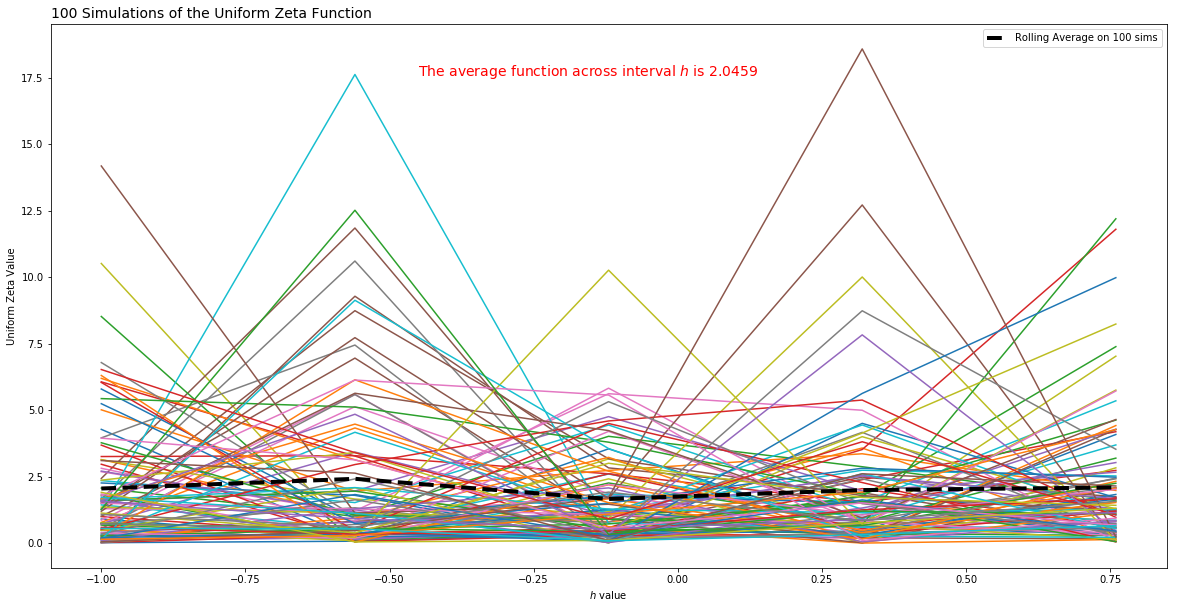

In [44]:
plt.figure(figsize=(20,10))  
plt.title("{} Simulations of the Uniform Zeta Function".format(uniform_sims), loc='left', size=14)
for i in uniform_zeta:
    plt.plot(x_uniform, i)
plt.plot(x_uniform, np.average(uniform_zeta, axis=0), lw=4, color='black', label='Rolling Average on {} sims'.format(uniform_sims), ls='--')
plt.text(-0.45, uniform_zeta.max()-1, 
         "The average function across interval $h$ is {}".format(round(np.average(np.average(uniform_zeta, axis=0)), 4)), 
         size=14, color='red')

plt.ylabel('Uniform Zeta Value')
plt.xlabel('$h$ value')
plt.legend()
plt.show()

In [37]:
# computes the max of the uniform zeta function 
uniform_max_fhk1 = lambda x: (np.log(x) /  (np.log(np.log(x))**0.75)) * np.exp(np.average(gumbel_r.rvs(loc=0, scale=0.5, size=1000)))

uniform_max_iid1 = lambda x: (np.log(x) /  (np.log(np.log(x))**0.25)) * np.exp(np.average(gumbel_r.rvs(loc=0, scale=0.5, size=1000)))

uniform_max_fhk2 = lambda x: (np.log(x) /  (np.log(np.log(x))**0.75)) * np.exp(-np.average(gumbel_r.rvs(loc=0, scale=0.5, size=1000)))

uniform_max_iid2 = lambda x: (np.log(x) /  (np.log(np.log(x))**0.25)) * np.exp(-np.average(gumbel_r.rvs(loc=0, scale=0.5, size=1000)))

In [50]:
# determining the conjecture maxes defined above
cong_iid_max = uniform_max_iid1(T_uniform)
cong_fhk_max = uniform_max_fhk1(T_uniform)

print('Implementanting an exponential Gumbel')
print("Our simulated maximum was        ->", np.average(uniform_zeta.max(axis=1)))
print("FHK Conjecture maximum should be ->", cong_fhk_max)
print("IID Conjecture maximum should be ->", cong_iid_max)

print()

# modifying the conjectures with a negative component 
cong_iid_max = uniform_max_iid2(T_uniform)
cong_fhk_max = uniform_max_fhk2(T_uniform)

print('Implementanting a negative exponential Gumbel')
print("Our simulated maximum was        ->", np.average(uniform_zeta.max(axis=1)))
print("FHK Conjecture maximum should be ->", cong_fhk_max)
print("IID Conjecture maximum should be ->", cong_iid_max)

Implementanting an exponential Gumbel
Our simulated maximum was        -> 5.276597987444563
FHK Conjecture maximum should be -> 9.803215038692745
IID Conjecture maximum should be -> 16.52843505373845

Implementanting a negative exponential Gumbel
Our simulated maximum was        -> 5.276597987444563
FHK Conjecture maximum should be -> 5.648649155347269
IID Conjecture maximum should be -> 9.356001290061734


Reflecting on the maximum conjecture for the Gumbel distribution it appears that the negative exponetial term appears to be in line with our simulated maximum. This is expressed below:
$$max_{|h|<1}|\zeta(1/2 + i(\tau +h))| = \frac{log(T)}{log_2(T)^{3/4}}\cdot e^{-M_t}$$

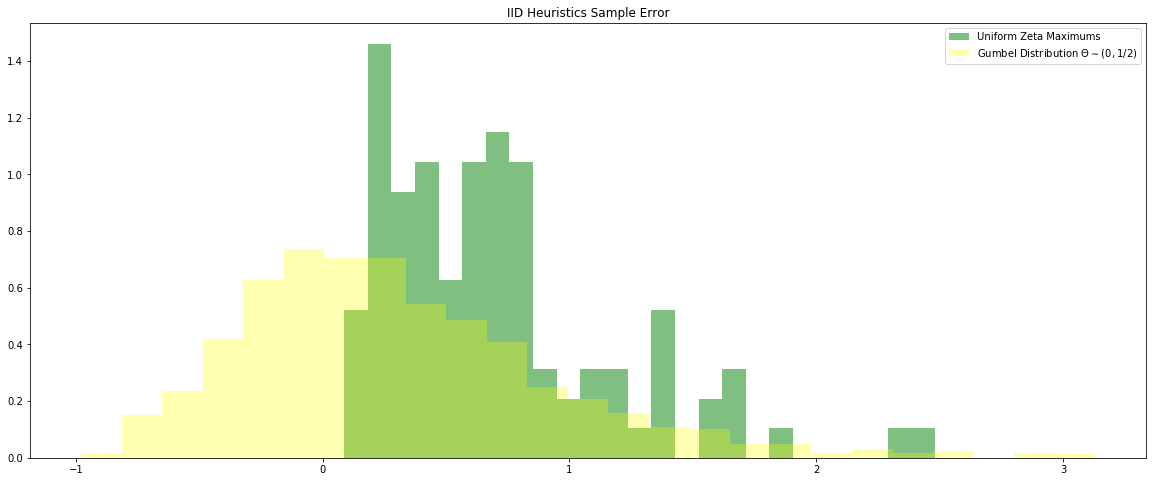

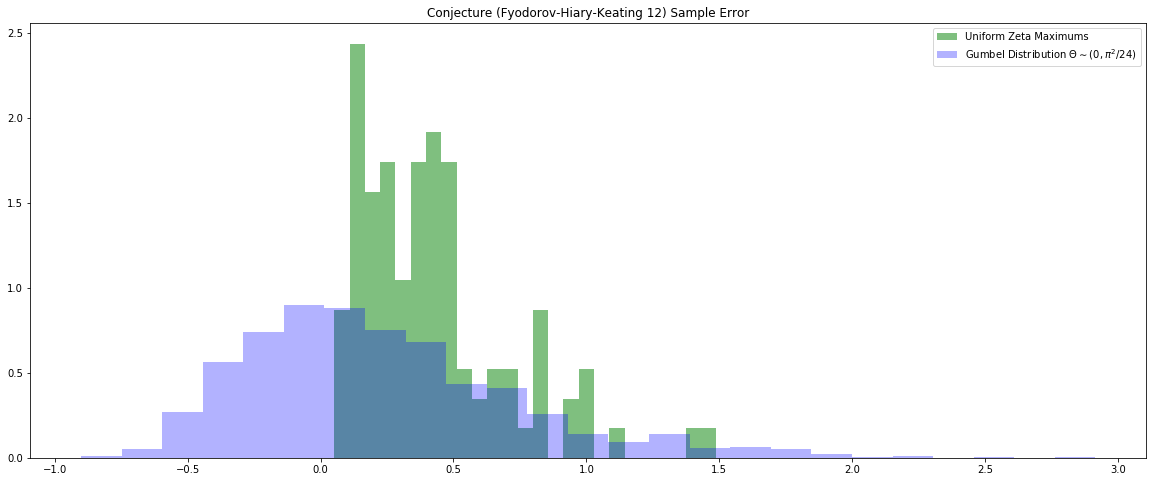

In [39]:
bins = 25
error1 = ( uniform_zeta.max(axis=1) / (np.log(T_uniform) /  (np.log(np.log(T_uniform))**0.75)) )
error2 = ( uniform_zeta.max(axis=1) / (np.log(T_uniform) /  (np.log(np.log(T_uniform))**0.25)) )
# examine evolution of T


# re-centered Gumbel distrubtion to observe the shape of the hist (variance 1/2)
plt.figure(figsize=(20, 8))
plt.title('IID Heuristics Sample Error')
plt.hist(error1, bins=bins, alpha=0.5, color='green', density=True, 
         label="Uniform Zeta Maximums") 
plt.hist(gumbel_r.rvs(loc=0, scale=0.5, size=1000), bins=bins, alpha=0.3, color='yellow', 
         label="Gumbel Distribution $\Theta \sim (0,1/2)$", density=True)
plt.legend()
plt.show()

# re-centered Gumbel distrubtion to observe the shape of the hist (variance pi^2/24)
plt.figure(figsize=(20, 8))
plt.title('Conjecture (Fyodorov-Hiary-Keating 12) Sample Error')
plt.hist(error2, bins=bins, alpha=0.5, color='green', density=True, 
         label="Uniform Zeta Maximums") 
plt.hist(gumbel_r.rvs(loc=0, scale=(np.pi**2)/24, size=1000), bins=bins, alpha=0.3, color='blue', 
         label="Gumbel Distribution $\Theta \sim (0,\pi^2/24)$", density=True)
plt.legend()
plt.show()

In [53]:
print('**Data Normalized Skew for Uniforms**')

# changes in T over time from 10^3 - 10^7
for t in [int(1e3), int(1e4), int(1e5), int(1e6), int(1e7)]:
    # simulate the temporary prime list
    sample_primes = prime_num[prime_num <= t]
    
    # generate the stochastic zeta funciton 
    temp_value = np.array([[zetaUniformNorm(T=t, h=H) for H in x_uniform] for _ in range(uniform_sims)])
    
    # generate the simulated maximum taking the average of the maxium of the paths 
    sim_max = np.average(temp_value.max(axis=1))
    
    # compute each error term (DIVIDE simulated maximum from conjecture)
    uni_error1_old = (sim_max / uniform_max_iid1(t))
    uni_error2_old = (sim_max / uniform_max_fhk1(t))
    uni_error1 = (sim_max / uniform_max_iid2(t))
    uni_error2 = (sim_max / uniform_max_fhk2(t))
    
    print('-------------------------------------------')
    print('The 1/4 power type 1 at T={} is {}'.format(('%.0e' % t), ('%.4f' % uni_error1_old)))
    print('The 3/4 power type 1 at T={} is {}'.format(('%.0e' % t), ('%.4f' % uni_error2_old)))
    print('---')
    print('The 1/4 power type 2 at T={} is {}'.format(('%.0e' % t), ('%.4f' % uni_error1)))
    print('The 3/4 power type 2 at T={} is {}'.format(('%.0e' % t), ('%.4f' % uni_error2)))

**Data Normalized Skew for Uniforms**
-------------------------------------------
The 1/4 power type 1 at T=1e+03 is 0.5463
The 3/4 power type 1 at T=1e+03 is 0.7545
---
The 1/4 power type 2 at T=1e+03 is 0.9962
The 3/4 power type 2 at T=1e+03 is 1.3797
-------------------------------------------
The 1/4 power type 1 at T=1e+04 is 0.4331
The 3/4 power type 1 at T=1e+04 is 0.6581
---
The 1/4 power type 2 at T=1e+04 is 0.7870
The 3/4 power type 2 at T=1e+04 is 1.1634
-------------------------------------------
The 1/4 power type 1 at T=1e+05 is 0.4273
The 3/4 power type 1 at T=1e+05 is 0.6468
---
The 1/4 power type 2 at T=1e+05 is 0.7308
The 3/4 power type 2 at T=1e+05 is 1.1138
-------------------------------------------
The 1/4 power type 1 at T=1e+06 is 0.4355
The 3/4 power type 1 at T=1e+06 is 0.6787
---
The 1/4 power type 2 at T=1e+06 is 0.8075
The 3/4 power type 2 at T=1e+06 is 1.2678
-------------------------------------------
The 1/4 power type 1 at T=1e+07 is 0.3819
The 3/4 powe